In [108]:
import pandas as pd
import psycopg2 as pg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score
import optuna
import pickle
from sklearn.feature_selection import SequentialFeatureSelector
reload_data = True
solo_trentino = True
all_seasons = False
import plotly.io as pio
pio.renderers.default = 'iframe'
from datetime import datetime
def norm(x):
    if len(x)==1 and x[0]=='':
        return []
    else:
        return x
if solo_trentino:
        engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
        if all_seasons is False:
            df = pd.read_sql('select * from fbk_export_08052024', con=engine) 
        else:
            df = pd.read_sql('select * from fbk_export_09052024', con=engine) 

else:
    if reload_data:
        #fbk_export_08052024
        engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
        df = pd.read_sql('select * from fbk_export_20240212', con=engine)
        with open('../src/data.pkl','wb') as f:
            pickle.dump(df,f)
    else:
        with open('../src/data.pkl','rb') as f:
            df = pickle.load(f)


    df = df[df.year>2015]
df['iii'] = list(range(df.shape[0]))
df['hour'] = df.dateandtime.apply(lambda x: x.hour)
df['dow'] = df.dateandtime.apply(lambda x: x.weekday())

/tmp/ipykernel_101408/3055773264.py:25: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [109]:
df.head()   ## provare ad aggiungere ora
            ## aggiungere regione? e lavorare solo trentino ##chiesto
            ## chiedere meteo ##chiesto
            ## numero incidenti giornalieri e gravita
            ## uso improprio delle ambulanze 
            ## max un mese (meta' maggio) --> 6 giugno campiglio 17.50 
            ## ingressi meteo e pista (MARCO)

            ## 

id               dateandtime  skiarea_id            skiarea_name  \
0  627685195 2024-04-27 08:00:00+00:00           8  Passo Tonale - Presena   
1  627685151 2024-04-20 10:40:00+00:00           8  Passo Tonale - Presena   
2  627685150 2024-04-20 09:00:00+00:00           8  Passo Tonale - Presena   
3  627685033 2024-04-14 12:30:00+00:00           6                Pampeago   
4  627685024 2024-04-14 09:15:00+00:00           8  Passo Tonale - Presena   

   day_of_year  minute_of_day  year  season    difficulty       cause  ...  \
0          118            480  2024    2024      advanced  fall_alone  ...   
1          111            640  2024    2024  intermediate     illness  ...   
2          111            540  2024    2024      advanced  fall_alone  ...   
3          105            750  2024    2024  intermediate     illness  ...   
4          105            555  2024    2024          easy  fall_alone  ...   

    diagnosis india   age country injury_side injury_general_location  \
0    fracture  None  52.0  Italia           R             lower_limbs   
1     malaise  None  51.0  Italia        None                    None   
2  distortion  None  48.0  Italia           R             lower_limbs   
3       other  None  26.0  Italia        None                    None   
4      bruise  None   9.0  Italia           L             lower_limbs   

         evacuation_vehicles iii  hour dow  
0          [ambulance, akja]   0     8   5  
1  [ski_lift, indipendently]   1    10   5  
2                [akja, car]   2     9   5  
3               [snowmobile]   3    12   6  
4               [snowmobile]   4     9   6  

[5 rows x 26 columns]

In [110]:
df.shape

(22324, 26)

In [111]:
aa = df.groupby('diagnosis').age.count().reset_index()
aa.sort_values(by='age',ascending=True,inplace=True)

import plotly.express as px
fig = px.bar(aa.rename(columns={'age':'count'}), y='diagnosis', x='count',width=800,height=1200)
fig.update_layout(
    xaxis_title="Counts",
    yaxis_title="Diagnosis",
   title = {
         'text': "Distribution of rescues by diagnosis",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },

        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig1.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig1.png") 
fig = px.bar(aa.rename(columns={'age':'count'}), y='diagnosis', x='count',width=800,height=1200,log_x=True)
fig.update_layout(
    xaxis_title="Counts (log scale)",
    yaxis_title="Diagnosis",
   title = {
         'text': "Distribution of rescues by diagnosis",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },

        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig1_log.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig1_log.png") 


Text(0, 0.5, 'Diagnosi')

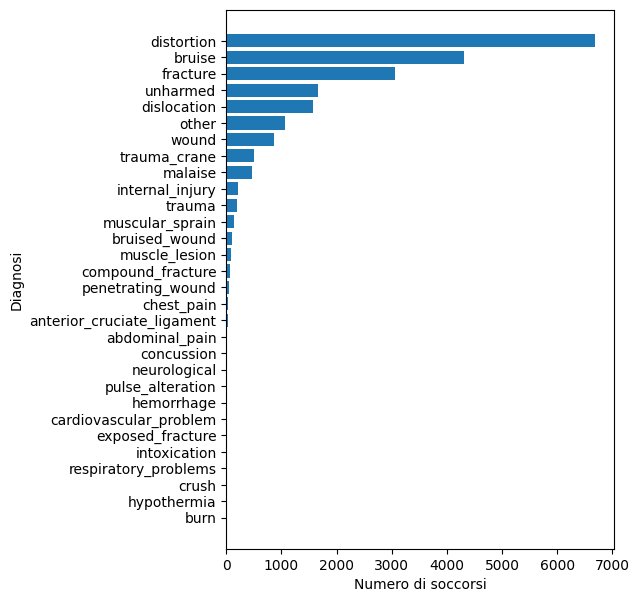

In [112]:
aa = df.groupby('diagnosis').age.count().reset_index()
aa.sort_values(by='age',ascending=True,inplace=True)
plt.figure(figsize = (5,7))
plt.barh(aa.diagnosis, aa.age)
plt.xlabel('Numero di soccorsi')
plt.ylabel('Diagnosi')

In [113]:
colors = [
    "rgb(0, 48, 143)",
    "rgb(65, 175, 26)",
    #"rgb(168, 227, 0)",
    "rgb(255, 201, 77)",
    "rgb(255, 107, 0)",
    "rgb(214, 11, 67)",
    ]


color_list=[[0, colors[0]],
    [1/10, colors[1]],  
    [5/10, colors[2]], 
    #[5/10, colors[3]], 
    [10/10, colors[4]]]


In [114]:
def plot_rr(df,c1,c2):
    diagnosis = df.groupby([c1,c2]).iii.count().reset_index()
    diagnosis = diagnosis.pivot(columns=c2,values='iii',index=c1).reset_index().fillna(0)
    diagnosis.columns.name = None
    diagnosis.index.name = None
    if c1=='skiarea_id':
        diagnosis.loc[:,c1]=diagnosis[c1].apply(lambda x:str(int(float(x))))
    diagnosis = diagnosis.set_index(c1)
    diagnosis['tot'] = diagnosis.sum(axis=1)
    diagnosis = diagnosis[diagnosis.tot>100]
    sus=[]
    tots = pd.DataFrame(diagnosis.sum(axis=0),columns=['n'])
    from scipy.stats.contingency import relative_risk
    for i in range(diagnosis.shape[0]):
        for j in range(diagnosis.shape[1]-1):
            result = relative_risk(int(diagnosis.values[i,j]), int(diagnosis.values[i,-1]), int(tots.values[j][0]), int(tots.values[-1][0]))
            ci = result.confidence_interval(confidence_level=0.95)
            if ((ci[0]>1) & (ci[1]>1)) | ((ci[0]<1) & (ci[1]<1)):
                sus.append({c1:diagnosis.index[i],c2:diagnosis.columns[j],'rr':np.round(result.relative_risk,2)})
            else:
                sus.append({c1:diagnosis.index[i],c2:diagnosis.columns[j],'rr':np.nan})
    sus = pd.DataFrame(sus)   
    import matplotlib.pyplot as plt
    import plotly.express as px
    sus.loc[sus.rr>10,'rr'] = 10
    ss = sus.pivot(columns=c2,values='rr',index=c1).reset_index().fillna(1)
    #plt.imshow(ss.values[:,2:].astype(float),aspect='auto')
    ss.index = ss[c1]
    ss = ss.drop(columns=c1)
    ss[ss==1] = np.nan

    #plt.colorbar()
    #x = ss.columns[2:]
    #y = ss.skiarea.values
    #plt.xticks(range(len(x)), x, fontsize=12);
    #plt.yticks(range(len(y)), y, fontsize=12);
    
    #fig.show()
    return diagnosis, ss

In [115]:
diagnosis,ss = plot_rr(df,'skiarea_id','diagnosis')
fig = px.imshow(ss.T,width=1200, height=1200, aspect="auto",  color_continuous_scale=color_list)
fig.update_coloraxes(showscale=True)

fig.update_layout(
    yaxis_title="Diagnosis",
    xaxis_title="Skiarea ID",
   title = {
         'text': "Relative risk Diagnosis-Skiarea",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },
        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
fig.show()
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig2.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig2.png") 

/tmp/ipykernel_101408/941372287.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '3' '4' '6' '7' '8' '9' '10' '11' '12' '17' '20' '24' '28' '31' '32'
 '36' '37' '51' '55' '58' '59' '61' '64' '65' '78' '81' '170']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [116]:
diagnosis,ss = plot_rr(df,'skiarea_id','dow')
fig = px.imshow(ss,width=1200, height=1200, aspect="auto",  color_continuous_scale=color_list)
fig.update_coloraxes(showscale=True)

fig.update_layout(
    xaxis_title="Day of the week",
    yaxis_title="Skiarea ID",
   title = {
         'text': "Relative risk Diagnosis-DOW",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },
        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
fig.show()
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig3.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig3.png") 
aa = df.groupby('dow').age.count().reset_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

aa.dow = aa.dow.apply(lambda x: days[x])
import plotly.express as px
fig = px.bar(aa.rename(columns={'age':'count'}), y='count', x='dow',width=800,height=800)
fig.update_layout(
    yaxis_title="Counts",
    xaxis_title="Day of the week",
   title = {
         'text': "Distribution of rescues by day of the week",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },

        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig4.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig4.png") 

/tmp/ipykernel_101408/941372287.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '3' '4' '6' '7' '8' '9' '10' '11' '12' '17' '20' '24' '28' '31' '32'
 '36' '37' '51' '55' '58' '59' '61' '64' '65' '78' '81' '170']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [117]:

diagnosis,ss = plot_rr(df,'skiarea_id','hour')
fig = px.imshow(ss,width=1200, height=1200, aspect="auto",  color_continuous_scale=color_list)
fig.update_coloraxes(showscale=True)
fig.update_layout(
    xaxis_title="Hour",
    yaxis_title="Skiarea ID",
   title = {
         'text': "Relative risk Diagnosis-Hour",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },
        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
fig.show()
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig5.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig5.png") 

aa = df.groupby('hour').age.count().reset_index()

import plotly.express as px
fig = px.bar(aa.rename(columns={'age':'count'}), y='count', x='hour',width=1000,height=600)
fig.update_layout(
    yaxis_title="Counts",
    xaxis_title="Hour",
   title = {
         'text': "Distribution of rescues by hour",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },

        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig6.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig6.png") 

/tmp/ipykernel_101408/941372287.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '3' '4' '6' '7' '8' '9' '10' '11' '12' '17' '20' '24' '28' '31' '32'
 '36' '37' '51' '55' '58' '59' '61' '64' '65' '78' '81' '170']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [118]:

diagnosis,ss = plot_rr(df,'hour','dow')
fig = px.imshow(ss,width=600, height=600, aspect="auto",  color_continuous_scale=color_list)
fig.update_coloraxes(showscale=True)
fig.update_layout(
    yaxis_title="Hour",
    xaxis_title="Dow",
   title = {
         'text': "Relative risk Dow-Hour",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },
        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
fig.show()
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig7.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig7.png") 

In [119]:

diagnosis,ss = plot_rr(df,'diagnosis','dow')
fig = px.imshow(ss,width=900, height=900, aspect="auto",  color_continuous_scale=color_list)
fig.update_coloraxes(showscale=True)
fig.update_layout(
    xaxis_title="Hour",
    yaxis_title="Diagnosis",
   title = {
         'text': "Relative risk Diagnosis-Hour",
         #'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },
        font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
fig.show()
if all_seasons:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig8.png") 
else:
    fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig8.png") 


In [120]:
if all_seasons:
    # 'weather', 'snow_condition',
    diagnosis,ss = plot_rr(df,'skiarea_id','weather')
    fig = px.imshow(ss,width=1200, height=1200, aspect="auto",  color_continuous_scale=color_list)
    fig.update_coloraxes(showscale=True)
    
    fig.update_layout(
        xaxis_title="Weather condition",
        yaxis_title="Skiarea ID",
       title = {
             'text': "Relative risk Diagnosis-DOW",
             #'y':0.9, # new
             'x':0.5,
             'xanchor': 'center',
             'yanchor': 'top' # new
            },
            font=dict(
            #family="Courier New, monospace",
            size=18,
            #color="RebeccaPurple"
        )
    )
    fig.show()
    if all_seasons:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig9.png") 
    else:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig9.png") 
    aa = df.groupby('weather').age.count().reset_index()

    import plotly.express as px
    fig = px.bar(aa.rename(columns={'age':'count'}), y='count', x='weather',width=800,height=800,log_y=True)
    fig.update_layout(
        yaxis_title="Counts (log scale)",
        xaxis_title="Weather condition",
       title = {
             'text': "Distribution of rescues by weather condition",
             #'y':0.9, # new
             'x':0.5,
             'xanchor': 'center',
             'yanchor': 'top' # new
            },
    
            font=dict(
            #family="Courier New, monospace",
            size=18,
            #color="RebeccaPurple"
        )
    )
    if all_seasons:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig10.png") 
    else:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig10.png") 




In [121]:
if all_seasons:
    # 'weather', 'snow_condition',
    diagnosis,ss = plot_rr(df,'skiarea_id','snow_condition')
    fig = px.imshow(ss,width=1200, height=1200, aspect="auto",  color_continuous_scale=color_list)
    fig.update_coloraxes(showscale=True)
    
    fig.update_layout(
        xaxis_title="Snow condition",
        yaxis_title="Skiarea ID",
       title = {
             'text': "Relative risk Diagnosis-DOW",
             #'y':0.9, # new
             'x':0.5,
             'xanchor': 'center',
             'yanchor': 'top' # new
            },
            font=dict(
            #family="Courier New, monospace",
            size=18,
            #color="RebeccaPurple"
        )
    )
    fig.show()
    if all_seasons:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig11.png") 
    else:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig11.png") 
    aa = df.groupby('snow_condition').age.count().reset_index()

    import plotly.express as px
    fig = px.bar(aa.rename(columns={'age':'count'}), y='count', x='snow_condition',width=800,height=800,log_y=True)
    fig.update_layout(
        yaxis_title="Counts (log scale)",
        xaxis_title="Snow condition",
       title = {
             'text': "Distribution of rescues by weather condition",
             #'y':0.9, # new
             'x':0.5,
             'xanchor': 'center',
             'yanchor': 'top' # new
            },
    
            font=dict(
            #family="Courier New, monospace",
            size=18,
            #color="RebeccaPurple"
        )
    )
    if all_seasons:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres_all_seasons/fig12.png") 
    else:
        fig.write_image("/home/agobbi/Projects/PID/datanalytics/PID/materiale_pres/fig12.png") 




In [102]:
df.columns

Index(['id', 'dateandtime', 'skiarea_id', 'skiarea_name', 'day_of_year',
       'minute_of_day', 'year', 'season', 'difficulty', 'cause', 'town',
       'province', 'gender', 'equipment', 'helmet', 'destination', 'diagnosis',
       'india', 'age', 'country', 'injury_side', 'injury_general_location',
       'evacuation_vehicles', 'weather', 'snow_condition', 'iii', 'hour',
       'dow'],
      dtype='object')

In [95]:
df_orig = df.copy()
with open('../src/test/metadata.pkl','rb') as f:
    to_remove,use_small,evacuations,encoders = pickle.load(f)

for c in evacuations:
    df[c] = False
df['other']  = False
for i,row in df.iterrows():
    evacuation = row.evacuation_vehicles
    for c in evacuation:
        df.loc[i,c] = True
        
    for c in evacuation:
        if c not in evacuations:
            df.loc[i,'other'] = True
            brea

df.drop(columns='evacuation_vehicles', inplace=True)


df['age'] =  df['age'].astype(np.float32)



for c in df.columns:
    if c not in ['india','age','season','skiarea_name','destination']:
        df[c] = df[c].astype('str')  
if use_small:
    for c in to_remove.keys():
        for k in to_remove[c]:
            df.loc[df[c]==k,c] = 'other'
if use_small:
    for c in encoders['small']:
        df.loc[~df[c].isin( encoders['small'][c].classes_),c] = 'other'
else:
    for c in encoders['normal']:
        df.loc[~df[c].isin( encoders['normal'][c].classes_),c] = 'other'

bst_FS = xgb.Booster()
bst_FS.load_model("../src/test/model.json")
for c in df.columns:
    if c not in ['age','season','skiarea_name','india']:
        df[c] =  df[c].fillna('None')
        if use_small:
            if c in bst_FS.feature_names:
                df[c] = pd.Categorical( encoders['small'][c].transform(df[c]), categories=list(range(len(encoders['small'][c].classes_))), ordered=False)
        else:
            if c in bst_FS.feature_names:
                df[c] = pd.Categorical( encoders['normal'][c].transform(df[c]), categories=list(range(len(encoders['normal'][c].classes_))), ordered=False)



dtest_FS = xgb.DMatrix(df[bst_FS.feature_names],enable_categorical=True)
preds = bst_FS.predict(dtest_FS)

In [96]:
df['computed_SI'] = preds.argmax(1)
df_orig['computed_SI'] = preds.argmax(1)

In [97]:
tmp = df[~pd.isnull(df.india)]
tmp.india = tmp.india.apply(lambda x:int(x[1]))
accuracy_score(tmp.india, tmp.computed_SI)

/tmp/ipykernel_101408/3067476809.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8162839248434238

In [35]:
diagnosis = plot_rr(df_orig,'skiarea_id','computed_SI')


/tmp/ipykernel_71942/1056303979.py:25: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_71942/1056303979.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

In [36]:
diagnosis = plot_rr(df_orig,'dow','computed_SI')


/tmp/ipykernel_71942/1056303979.py:25: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_71942/1056303979.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

In [37]:
diagnosis = plot_rr(tmp,'helicopter','computed_SI')
diagnosis

/tmp/ipykernel_71942/1056303979.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_71942/1056303979.py:25: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in th

0    1   2  3  tot
helicopter                     
0           16  184  52  0  252

In [38]:
diagnosis = plot_rr(df,'helicopter','computed_SI')
diagnosis

/tmp/ipykernel_71942/1056303979.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_71942/1056303979.py:25: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in th

0      1     2    3   4    tot
helicopter                                   
0           3747  13926  4049   13  19  21754
1              3      1   428  138   0    570

In [ ]:
0	1243	11696	4646	57	5	17647
1	5	0	621	144	2	772

In [99]:
df.groupby('computed_SI').skiarea_id.count().reset_index()

computed_SI  skiarea_id
0            0       10385
1            1       40284
2            2       13569
3            3         497
4            4          62

In [100]:
df.groupby('india').skiarea_id.count().reset_index()

india  skiarea_id
0    i0          15
1    i1         355
2    i2         105
3    i3           4

In [179]:
## posso anche vedere se ci sono delle aree sciistiche con pattern simili!
diagnosis = df[df.year>2015].groupby(['skiarea_id','diagnosis']).age.count().reset_index()
diagnosis = diagnosis.pivot(columns='diagnosis',values='age',index='skiarea_id').reset_index().fillna(0)
diagnosis.columns.name = None
diagnosis.index.name = None
diagnosis.skiarea_id=diagnosis.skiarea_id.apply(lambda x:str(int(float(x))))
diagnosis = diagnosis.set_index('skiarea_id')
diagnosis['tot'] = diagnosis.sum(axis=1)
diagnosis = diagnosis[diagnosis.tot>20]
diagnosis = diagnosis.apply(lambda x:x/x.tot,axis=1)


In [180]:
diagnosis

abdominal_pain  anterior_cruciate_ligament    bruise  \
skiarea_id                                                         
1                 0.000000                    0.000743  0.215825   
2                 0.001193                    0.008948  0.241996   
3                 0.000576                    0.000863  0.241151   
4                 0.000000                    0.004695  0.247261   
5                 0.000000                    0.000242  0.246496   
...                    ...                         ...       ...   
159               0.000000                    0.000000  0.123288   
162               0.000000                    0.000000  0.295455   
166               0.000000                    0.000000  0.181818   
167               0.000000                    0.027149  0.176471   
170               0.000000                    0.000000  0.235772   

            bruised_wound  burn  cardiovascular_problem  chest_pain  \
skiarea_id                                                            
1                0.001114   0.0                0.000000    0.000000   
2                0.003778   0.0                0.000994    0.001193   
3                0.002158   0.0                0.000144    0.000432   
4                0.000782   0.0                0.000000    0.002347   
5                0.001450   0.0                0.000242    0.000000   
...                   ...   ...                     ...         ...   
159              0.027397   0.0                0.006849    0.006849   
162              0.007576   0.0                0.000000    0.000000   
166              0.000000   0.0                0.000000    0.045455   
167              0.018100   0.0                0.000000    0.004525   
170              0.000000   0.0                0.000000    0.008130   

            compound_fracture  concussion     crush  ...     other  paralysis  \
skiarea_id                                           ...                        
1                    0.001857    0.000000  0.000000  ...  0.151560   0.000000   
2                    0.000199    0.000994  0.000000  ...  0.117916   0.000000   
3                    0.003022    0.000719  0.000144  ...  0.054532   0.000144   
4                    0.003912    0.000000  0.000000  ...  0.091549   0.000000   
5                    0.000967    0.000483  0.000000  ...  0.041808   0.000000   
...                       ...         ...       ...  ...       ...        ...   
159                  0.020548    0.000000  0.000000  ...  0.150685   0.000000   
162                  0.000000    0.007576  0.000000  ...  0.015152   0.000000   
166                  0.090909    0.000000  0.000000  ...  0.000000   0.000000   
167                  0.000000    0.018100  0.000000  ...  0.013575   0.000000   
170                  0.000000    0.000000  0.000000  ...  0.048780   0.000000   

            penetrating_wound  pulse_alteration  respiratory_problems  \
skiarea_id                                                              
1                    0.000743          0.000371              0.000371   
2                    0.001193          0.000398              0.000398   
3                    0.000576          0.000288              0.000144   
4                    0.000000          0.001565              0.000000   
5                    0.000242          0.000000              0.000000   
...                       ...               ...                   ...   
159                  0.000000          0.000000              0.000000   
162                  0.000000          0.000000              0.000000   
166                  0.000000          0.000000              0.000000   
167                  0.027149          0.000000              0.000000   
170                  0.000000          0.000000              0.000000   

              trauma  trauma_crane  unharmed     wound  tot  
skiarea_id                                                   
1           0.007058      0.008172  0.073923  0.052006  1.0  
2           0

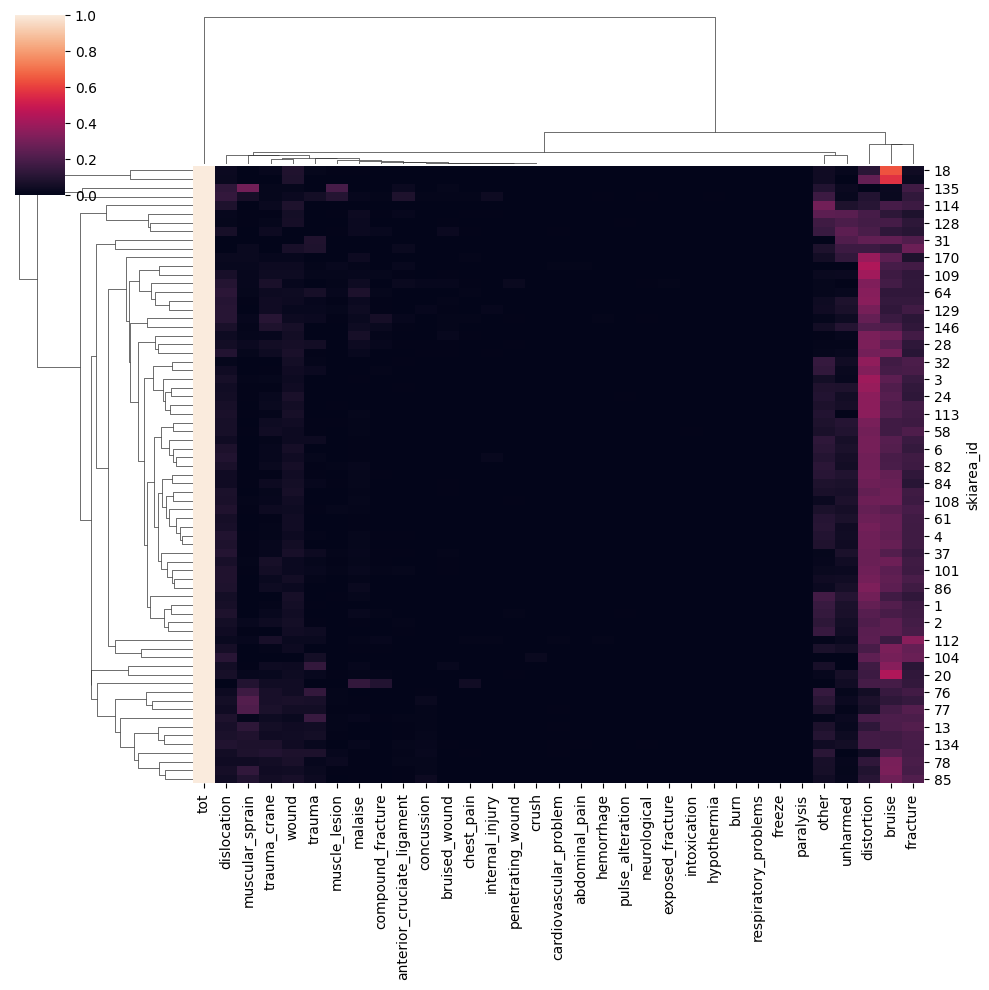

In [182]:
import seaborn as sns
sns.clustermap(diagnosis)


In [205]:
diagnosis = df.groupby(['skiarea_id','diagnosis']).age.count().reset_index()
diagnosis = diagnosis.pivot(columns='diagnosis',values='age',index='skiarea_id').reset_index().fillna(0)
diagnosis.columns.name = None
diagnosis.index.name = None
diagnosis.skiarea_id=diagnosis.skiarea_id.apply(lambda x:str(int(float(x))))
diagnosis = diagnosis.set_index('skiarea_id')
diagnosis['tot'] = diagnosis.sum(axis=1)
diagnosis = diagnosis[diagnosis.tot>100]
sus=[]
tots = pd.DataFrame(diagnosis.sum(axis=0),columns=['n'])
from scipy.stats.contingency import relative_risk
for i in range(diagnosis.shape[0]):
    for j in range(diagnosis.shape[1]-1):
        result = relative_risk(int(diagnosis.values[i,j]), int(diagnosis.values[i,-1]), int(tots.values[j][0]), int(tots.values[-1][0]))
        ci = result.confidence_interval(confidence_level=0.95)
        if ((ci[0]>1) & (ci[1]>1)) | ((ci[0]<1) & (ci[1]<1)):
            sus.append({'skiarea':diagnosis.index[i],'diagnosis':diagnosis.columns[j],'rr':np.round(result.relative_risk,2)})
sus = pd.DataFrame(sus)   
import matplotlib.pyplot as plt
import plotly.express as px
sus.rr[sus.rr>10] = 10
ss = sus.pivot(columns='diagnosis',values='rr',index='skiarea').reset_index().fillna(1)
#plt.imshow(ss.values[:,2:].astype(float),aspect='auto')
ss.index = ss.skiarea
ss = ss.drop(columns='skiarea')


/tmp/ipykernel_218931/2034767285.py:21: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




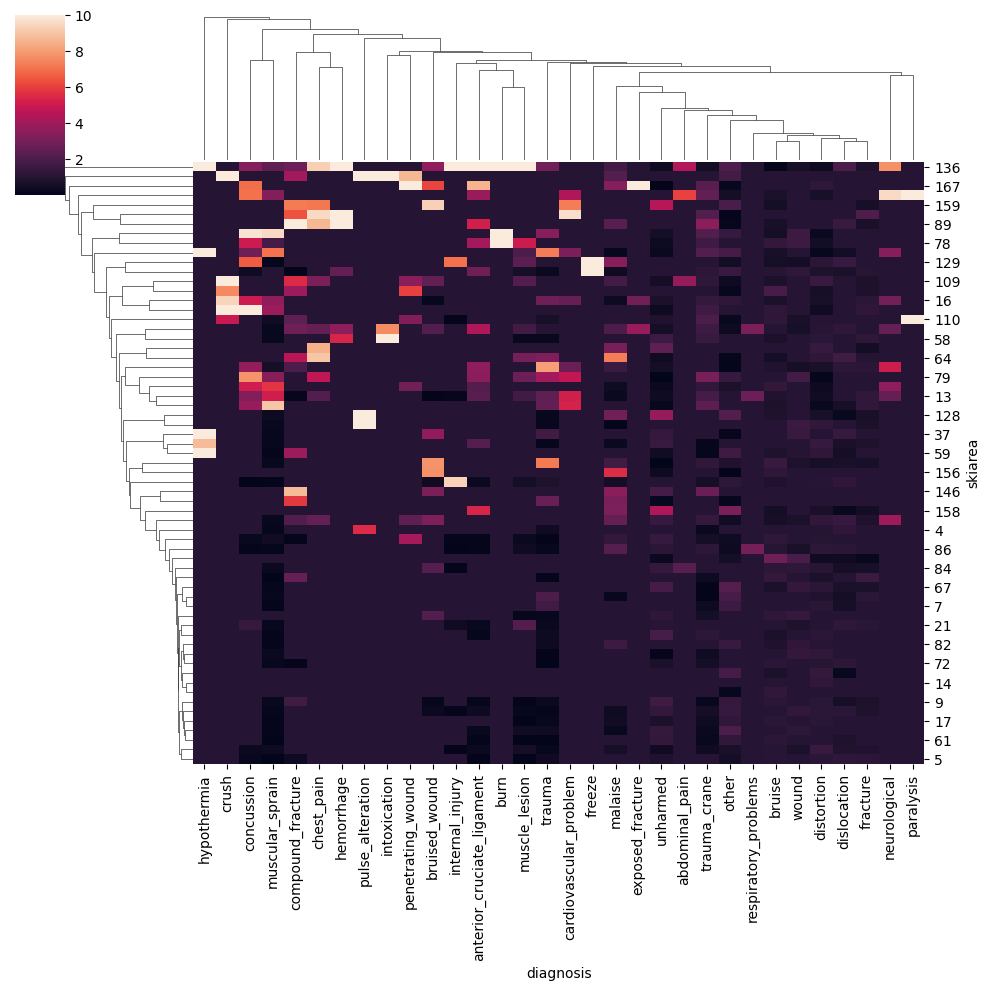

In [190]:
sns.clustermap(ss)


In [206]:
import dash_bio

dash_bio.Clustergram(
    data=ss,
    center_values=False,

    column_labels=list(ss.columns.values),
    row_labels=list(ss.index),
    height=1200,
    width=1200,
)

In [196]:
diagnosis = df_orig.groupby(['skiarea_id','computed_SI']).age.count().reset_index()
diagnosis = diagnosis.pivot(columns='computed_SI',values='age',index='skiarea_id').reset_index().fillna(0)
diagnosis.columns.name = None
diagnosis.index.name = None
diagnosis.skiarea_id=diagnosis.skiarea_id.apply(lambda x:str(int(float(x))))

diagnosis = diagnosis.set_index('skiarea_id')
diagnosis['tot'] = diagnosis.sum(axis=1)
diagnosis = diagnosis[diagnosis.tot>100]
sus = []
tots = pd.DataFrame(diagnosis.sum(axis=0),columns=['n'])
from scipy.stats.contingency import relative_risk
for i in range(diagnosis.shape[0]):
    for j in range(diagnosis.shape[1]-1):
        result = relative_risk(int(diagnosis.values[i,j]), int(diagnosis.values[i,-1]), int(tots.values[j][0]), int(tots.values[-1][0]))
        ci = result.confidence_interval(confidence_level=0.95)
        if ((ci[0]>1) & (ci[1]>1)) | ((ci[0]<1) & (ci[1]<1)):
            sus.append({'skiarea':diagnosis.index[i],'computed_SI':diagnosis.columns[j],'rr':result.relative_risk})
sus = pd.DataFrame(sus)   
import matplotlib.pyplot as plt
import plotly.express as px
sus.rr[sus.rr>10] = 10
ss = sus.pivot(columns='computed_SI',values='rr',index='skiarea').reset_index().fillna(1)
#plt.imshow(ss.values[:,2:].astype(float),aspect='auto')
ss.index = ss.skiarea
ss = ss.drop(columns='skiarea')
fig = px.imshow(ss,width=1200, height=1200, aspect="auto",  color_continuous_scale=color_list)
fig.update_coloraxes(showscale=True)
#plt.colorbar()
#x = ss.columns[2:]
#y = ss.skiarea.values
#plt.xticks(range(len(x)), x, fontsize=12);
#plt.yticks(range(len(y)), y, fontsize=12);
import plotly.io as pio
pio.renderers.default = 'iframe'
fig.show()

/tmp/ipykernel_218931/2465247991.py:22: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [203]:
ss.values.min()

0.2031521389902816

In [204]:
import dash_bio

dash_bio.Clustergram(
    data=ss,
    center_values=False,
    column_labels=list(ss.columns.values),
    row_labels=list(ss.index),
    height=1200,
    width=1200,
)